In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt
import math

%matplotlib inline
plt.style.use("ggplot")

In [2]:
import yfinance as yf

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return(data - data.shift(1))/data.shift(1)

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Read Portfolios and trading Strategies

In [3]:
%run -i 'portfolio.py'

In [4]:
data = pd.read_csv("./data/portfolio_dataset.csv", low_memory=False)#, nrows= 10000)

data["datadate"] = pd.to_datetime(data["datadate"])
print("Number of unique tickers:",len(data.tic.value_counts()))
data = data[["datadate","tic","div","cshoc","prccd"]].sort_values(by= "datadate")\
                                                .rename({'cshoc':'shares',
                                                #     'prchd':'high',
                                                #     'prcld':'low',
                                                #     'prcod':'open',
                                                        'prccd':'close',}, axis = 1).\
                                                reset_index(drop=True)
data = data[data["datadate"] >= pd.to_datetime("01-01-2010")]



data["div"] = data["div"].fillna(0)
print("Dimensions: ",data.shape)
data

Number of unique tickers: 1230
Dimensions:  (2331936, 5)


,datadate,tic,div,shares,close
0,2010-01-04,AAMRQ,0.0,3.324560e+08,7.720
1,2010-01-04,MRO,0.0,7.078450e+08,32.110
2,2010-01-04,PCS,0.0,3.524010e+08,7.970
3,2010-01-04,LOW,0.0,1.472032e+09,23.160
4,2010-01-04,GOOGL,0.0,2.429990e+08,626.750
...,...,...,...,...,...
2331931,2021-10-08,ZIONO,0.0,5.536000e+06,27.520
2331932,2021-10-08,ZIONP,0.0,2.646000e+06,25.005
2331933,2021-10-08,BKNG,0.0,4.106000e+07,2474.370
2331934,2021-10-08,TJX,0.0,1.202539e+09,64.740


***

# S&P 500 Replicating Portfolio

## Fetch S&P 500 Index Constituent Data

In [5]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# driver.get(url)

# def get_text(x):
#     return x.text

In [6]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[1]'
# spy_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     spy_ticker_set.add(get_text(item))
# print(len(spy_ticker_set))
# # spy_ticker_set
# driver.close()

In [7]:
# with open('./data/spy_ticker.txt', 'w') as f:
#     for item in spy_ticker_set:
#         f.write("%s\n" % item)

## Read S&P 500 Index Constituent Data

- Wikipedia Method

In [8]:
# spy_ticker_set = set()
# with open('./data/spy_ticker.txt') as f:
#     spy_ticker_set = f.readlines()
#     spy_ticker_set = {x.strip() for x in spy_ticker_set}
# print(len(spy_ticker_set))

- WRDS Method _(includes historical data)_

In [9]:
spy_ticker_data = pd.read_csv("./data/sp500_constituents.csv")
spy_ticker_set = set(spy_ticker_data["Symbol"])
print("Unique Indices:",len(spy_ticker_set))
spy_ticker = dict()
for year in spy_ticker_data["Year"].unique():
    spy_ticker[year] = list(spy_ticker_data[spy_ticker_data["Year"] == year]["Symbol"])
# spy_ticker

Unique Indices: 757


Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [10]:
spy_dataframe = data[data["datadate"] >= pd.to_datetime("01-01-2010")]

# Temporay measure b/c our spy_ticker does not have 2021 data
spy_dataframe = data[data["datadate"] <= pd.to_datetime("01-01-2021")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

Number of unique tickers: 1190
Dimensions:  (2183146, 5)
datadate        0
tic             0
div             0
shares      49497
close         553
dtype: int64


,datadate,tic,div,shares,close
5592,2010-01-13,Z.1,0.1546,NaN,NaN
8973,2010-01-20,RRD.2,0.2721,NaN,NaN
12443,2010-01-27,5050B,0.1950,NaN,NaN
20504,2010-02-10,0051B,0.1250,NaN,NaN
20505,2010-02-10,0050B,0.0730,NaN,NaN
...,...,...,...,...,...
2141545,2020-10-15,Z.1,0.1983,NaN,NaN
2142940,2020-10-16,PLP.Z,0.5671,NaN,NaN
2165919,2020-11-30,6525B,0.4005,NaN,NaN
2173465,2020-12-14,AHC.2,0.3187,NaN,NaN


**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [11]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

datadate        0
tic             0
div             0
shares      48944
close           0
dtype: int64


In [12]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

div        shares   close
datadate   tic                              
2010-01-04 AAMRQ   0.0  3.324560e+08    7.72
           MRO     0.0  7.078450e+08   32.11
           PCS     0.0  3.524010e+08    7.97
           LOW     0.0  1.472032e+09   23.16
           GOOGL   0.0  2.429990e+08  626.75
...                ...           ...     ...
2020-12-31 EXR     0.0  1.292350e+08  115.86
           AON     0.0  2.286160e+08  211.27
           BAC.PM  0.0  5.590000e+07   27.31
           MSI     0.0  1.695230e+08  170.06
           L       0.0  2.748730e+08   45.02

[2182593 rows x 3 columns]

In [13]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [14]:
# ;
# %run -i 'portfolio.py'

In [15]:
spy_trading_algo = SNP500_Algo("S&P 500 Algo")
spy_portfolio = Portfolio(target="S&P 500",
                        tickerset= spy_ticker, investment= 1000000,
                        trading_algo= spy_trading_algo,
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Target Index: S&P 500
Trading Algorithm: S&P 500 Algo
Starting Investment: 1000000
Current Investment: 1000000


In [16]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = spy_data.loc[date,:]
    valuation, returns =  spy_portfolio.run(date= date, price= tmpdf, tickerlist = spy_ticker[date.year])
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010


<string>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Rebalancing on: 01-Apr-2010
	Rebalancing on: 01-Jul-2010
	Rebalancing on: 01-Oct-2010
Reconstitution on: 03-Jan-2011
	Rebalancing on: 03-Jan-2011
	Rebalancing on: 01-Apr-2011
	Rebalancing on: 01-Jul-2011
	Rebalancing on: 03-Oct-2011
Reconstitution on: 03-Jan-2012
	Rebalancing on: 03-Jan-2012
	Rebalancing on: 02-Apr-2012
	Rebalancing on: 02-Jul-2012
	Rebalancing on: 01-Oct-2012
2012-10-26 00:00:00 2012-10-29 -1 -1
Reconstitution on: 02-Jan-2013
	Rebalancing on: 02-Jan-2013
	Rebalancing on: 01-Apr-2013
	Rebalancing on: 01-Jul-2013
	Rebalancing on: 01-Oct-2013
Reconstitution on: 02-Jan-2014
	Rebalancing on: 02-Jan-2014


In [ ]:
spy_portfolio.echo()
# print("Net return since start: ",spy_portfolio.net_return()*100,"%")

Target Index: S&P 500
Trading Algorithm: S&P 500 Algo
Starting Investment: 1000000
Current Investment: 3083313.277947321
Constituent Indices: MMM, ABT, ABBV, ABMD, ACN ...
Constituent Weights: tic
LKQ      28.463803
TTWO     10.695359
ORCL    281.640800
BAC     810.446449
GPS      34.946179
dtype: float64


In [ ]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns.fillna(1)+1)-1)*100,"%")

daily return:  0.04110993685435549 %


## S&P Index, ETF and Mutual Fund

In [ ]:
benchmark_data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2020-12-31")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,113.330002,104.320000,1132.989990
2010-01-05,113.629997,104.650002,1136.520020
2010-01-06,113.709999,104.750000,1137.140015
2010-01-07,114.190002,105.180000,1141.689941
2010-01-08,114.570000,105.480003,1144.979980


In [ ]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.002647,0.003163,0.003116
2010-01-06,0.000704,0.000956,0.000546
2010-01-07,0.004221,0.004105,0.004001
2010-01-08,0.003328,0.002852,0.002882


## Plot

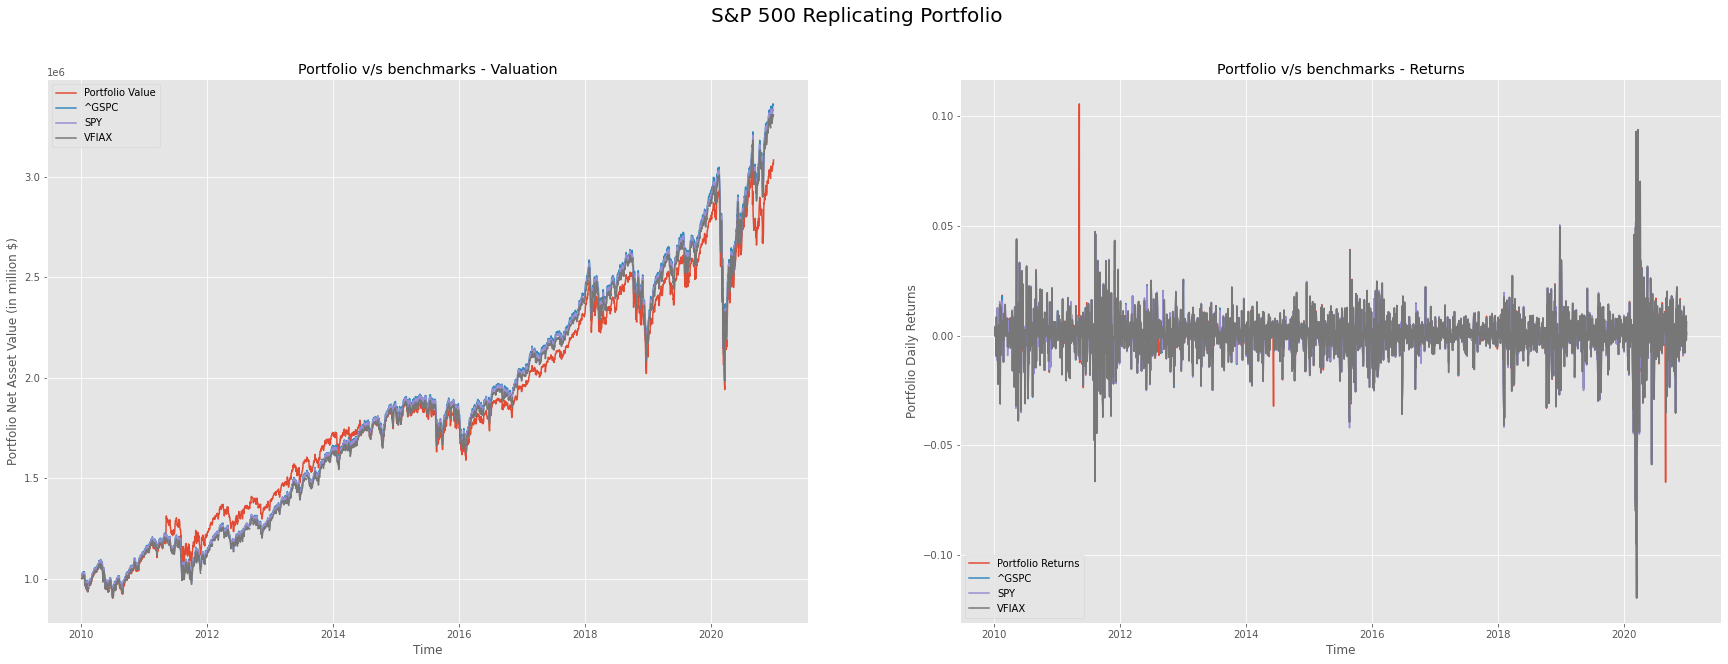

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot(benchmark_data["^GSPC"]*900)
ax[0].plot(benchmark_data["SPY"]*8961.3)
ax[0].plot(benchmark_data["VFIAX"]*9600)
ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^GSPC"])
ax[1].plot(baseline_return["SPY"])
ax[1].plot(baseline_return["VFIAX"])
ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

In [ ]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and SPY is 0.268%
Tracking error between our portfolio and VFIAX is 0.329%
Tracking error between our portfolio and ^GSPC is 0.254%


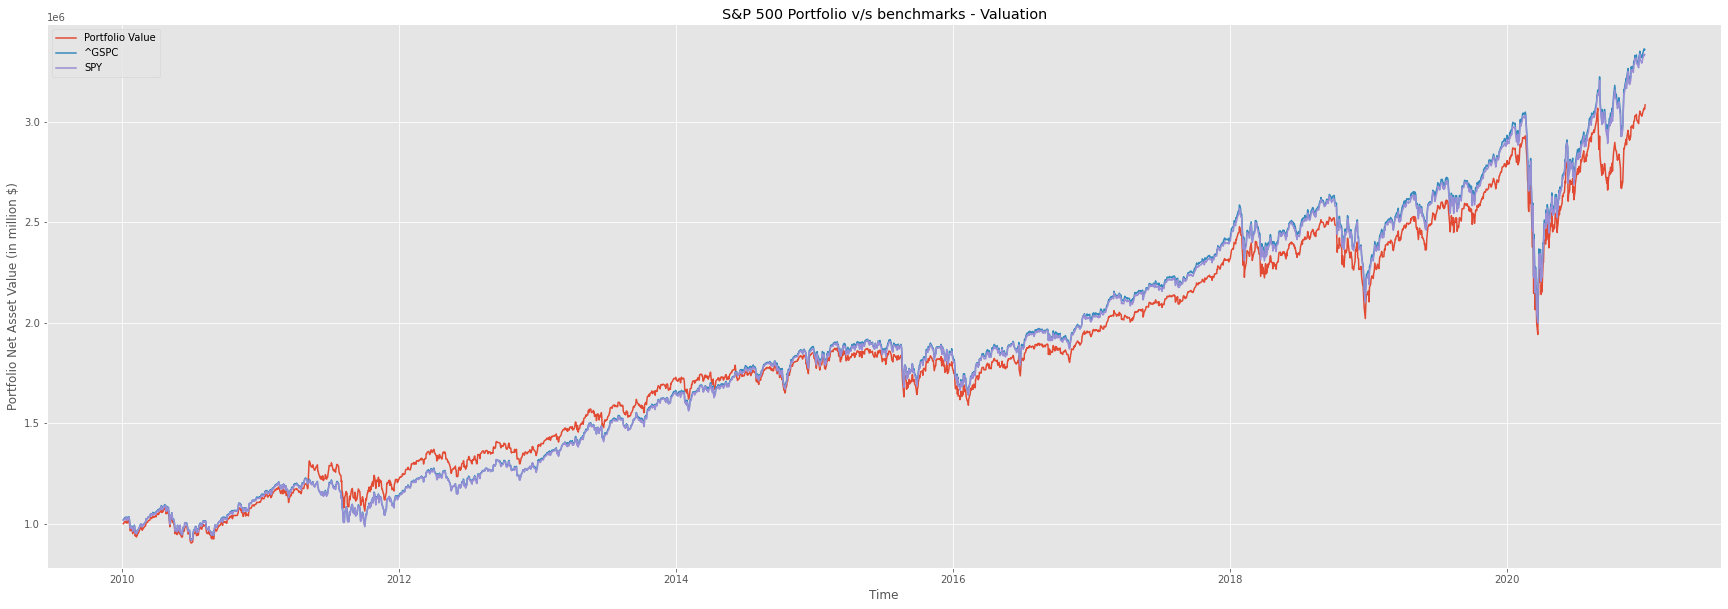

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot(benchmark_data["^GSPC"]*900)
plt.plot(benchmark_data["SPY"]*8961.3)
# plt.plot(benchmark_data["VFIAX"]*9600)
plt.legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("S&P 500 Portfolio v/s benchmarks - Valuation")
plt.show()

***

# DJIA Replicating Portfolio

## Fetch DJIA Index Constituent Data

In [ ]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
# driver.get(url)

# def get_text(x):
#     return x.text

In [ ]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[2]/a'
# djia_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     djia_ticker_set.add(get_text(item))
# print(len(djia_ticker_set))
# driver.close()
# # djia_ticker_set

In [ ]:
# with open('./data/djia_ticker.txt', 'w') as f:
#     for item in djia_ticker_set:
#         f.write("%s\n" % item)

## Read DJIA Index Constituent Data

- Wikipedia Method

In [ ]:
# djia_ticker_set = set()
# with open('./data/djia_ticker.txt') as f:
#     djia_ticker_set = f.readlines()
#     djia_ticker_set = {x.strip() for x in djia_ticker_set}
# print(len(djia_ticker_set))

- WRDS Method _(includes historical data)_

In [ ]:
djia_ticker_data = pd.read_csv("./data/dj_constituents.csv")
djia_ticker_set = set(djia_ticker_data["Symbol"])
print("Unique Indices:",len(djia_ticker_data))
djia_ticker = dict()
for year in djia_ticker_data["Year"].unique():
    djia_ticker[year] = list(djia_ticker_data[djia_ticker_data["Year"] == year]["Symbol"])
djia_ticker

Unique Indices: 330


{2010: ['MMM',
  'DD',
  'MCD',
  'AA',
  'XOM',
  'MRK',
  'AXP',
  'GE',
  'MSFT',
  'T',
  'HP',
  'PFE',
  'BAC',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'KFT',
  'DIS'],
 2011: ['MMM',
  'DD',
  'MCD',
  'AA',
  'XOM',
  'MRK',
  'AXP',
  'GE',
  'MSFT',
  'T',
  'HP',
  'PFE',
  'BAC',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'KFT',
  'DIS'],
 2012: ['MMM',
  'DD',
  'MRK',
  'AA',
  'XOM',
  'MSFT',
  'AXP',
  'GE',
  'PFE',
  'T',
  'HPQ',
  'PG',
  'BAC',
  'HD',
  'TRV',
  'BA',
  'INTC',
  'UNH',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'MCD',
  'DIS'],
 2013: ['MMM',
  'GE',
  'NKE',
  'AXP',
  'GS',
  'PFE',
  'T',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UNH',
  'CVX',
  'JNJ',
  'UTX',
  'CSCO',
  'JPM',
  'VZ',
  '

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [ ]:
djia_dataframe = data[data["tic"].apply(lambda x: (x in djia_ticker_set))].copy()
djia_dataframe = djia_dataframe[djia_dataframe["datadate"] >= pd.to_datetime("01-01-2010")]
print("Number of unique tickers:",len(djia_dataframe.tic.value_counts()))
djia_data = djia_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",djia_data.shape)
print(djia_data.isna().sum())
djia_data[np.isnan(djia_data.close)]

Number of unique tickers: 39
Dimensions:  (111530, 5)
datadate    0
tic         0
div         0
shares      9
close       0
dtype: int64


,datadate,tic,div,shares,close


In [ ]:
djia_data = djia_data.set_index(["datadate","tic"])
djia_data

div        shares   close
datadate   tic                            
2010-01-04 MMM   0.0  7.079580e+08   83.02
           MRK   0.0  3.054476e+09   37.01
           MCD   0.0  1.079187e+09   62.78
           CRM   0.0  1.249000e+08   74.82
           HD    0.0  1.700412e+09   28.67
...              ...           ...     ...
2021-10-08 HON   0.0  6.903990e+08  217.70
           GS    0.0  3.397620e+08  392.81
           WBA   0.0  8.649870e+08   47.38
           WMT   0.0  2.788498e+09  139.66
           MSFT  0.0  7.514891e+09  294.85

[111530 rows x 3 columns]

In [ ]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],djia_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [ ]:
# ;
# %run -i 'portfolio.py'

In [ ]:
djia_trading_algo = DJIA_Algo("Dow Jones Algo")

djia_portfolio = Portfolio(target="DJIA",
                        tickerset = djia_ticker, investment= 1000000,
                        trading_algo= djia_trading_algo,
                        rebalance=1, reconstitute=12)

# djia_portfolio.echo()

In [ ]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = djia_data.loc[date,:]
    
    valuation, returns =  djia_portfolio.run(date= date, price= tmpdf, tickerlist = djia_ticker[date.year])
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
    # print(date.strftime("%d-%m-%Y"), valuation, returns)

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010
	Rebalancing on: 05-Jan-2010
	Rebalancing on: 06-Jan-2010
	Rebalancing on: 07-Jan-2010
	Rebalancing on: 08-Jan-2010
	Rebalancing on: 11-Jan-2010
	Rebalancing on: 12-Jan-2010
	Rebalancing on: 13-Jan-2010
	Rebalancing on: 14-Jan-2010
	Rebalancing on: 15-Jan-2010
	Rebalancing on: 19-Jan-2010
	Rebalancing on: 20-Jan-2010
	Rebalancing on: 21-Jan-2010
	Rebalancing on: 22-Jan-2010
	Rebalancing on: 25-Jan-2010
	Rebalancing on: 26-Jan-2010
	Rebalancing on: 27-Jan-2010
	Rebalancing on: 28-Jan-2010
	Rebalancing on: 29-Jan-2010
	Rebalancing on: 01-Feb-2010
	Rebalancing on: 02-Feb-2010
	Rebalancing on: 03-Feb-2010
	Rebalancing on: 04-Feb-2010
	Rebalancing on: 05-Feb-2010
	Rebalancing on: 08-Feb-2010
	Rebalancing on: 09-Feb-2010
	Rebalancing on: 10-Feb-2010
	Rebalancing on: 11-Feb-2010
	Rebalancing on: 12-Feb-2010
	Rebalancing on: 16-Feb-2010
	Rebalancing on: 17-Feb-2010
	Rebalancing on: 18-Feb-2010
	Rebalancing on: 19-Feb-2010
	Rebalancing

KeyError: 2021

In [ ]:
djia_portfolio.echo()
# print("Net return since start: ",djia_portfolio.net_return()*100,"%")

Target Index: DJIA
Trading Algorithm: Dow Jones Algo
Starting Investment: 1000000
Current Investment: 2618085.6255883463
Constituent Indices: MMM, GS, NKE, AXP, HD ...
Constituent Weights: tic
HON    562.812514
PG     562.812514
DIS    562.812514
BA     562.812514
VZ     562.812514
dtype: float64


In [ ]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

daily return:  0.033079633043442414 %


## DJIA Index, ETF and Mutual Fund(Not yet available)

In [ ]:
benchmark_data = yf.download("^DJI DIA VTSMX", start="2010-01-01", end="2021-10-07")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,DIA,VTSMX,^DJI
Date,,,
2010-01-04,105.660004,27.910000,10583.959961
2010-01-05,105.489998,27.990000,10572.019531
2010-01-06,105.559998,28.030001,10573.679688
2010-01-07,105.940002,28.150000,10606.860352
2010-01-08,106.110001,28.240000,10618.190430


In [ ]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,DIA,VTSMX,^DJI
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,-0.001609,0.002866,-0.001128
2010-01-06,0.000664,0.001429,0.000157
2010-01-07,0.003600,0.004281,0.003138
2010-01-08,0.001605,0.003197,0.001068


## Plot

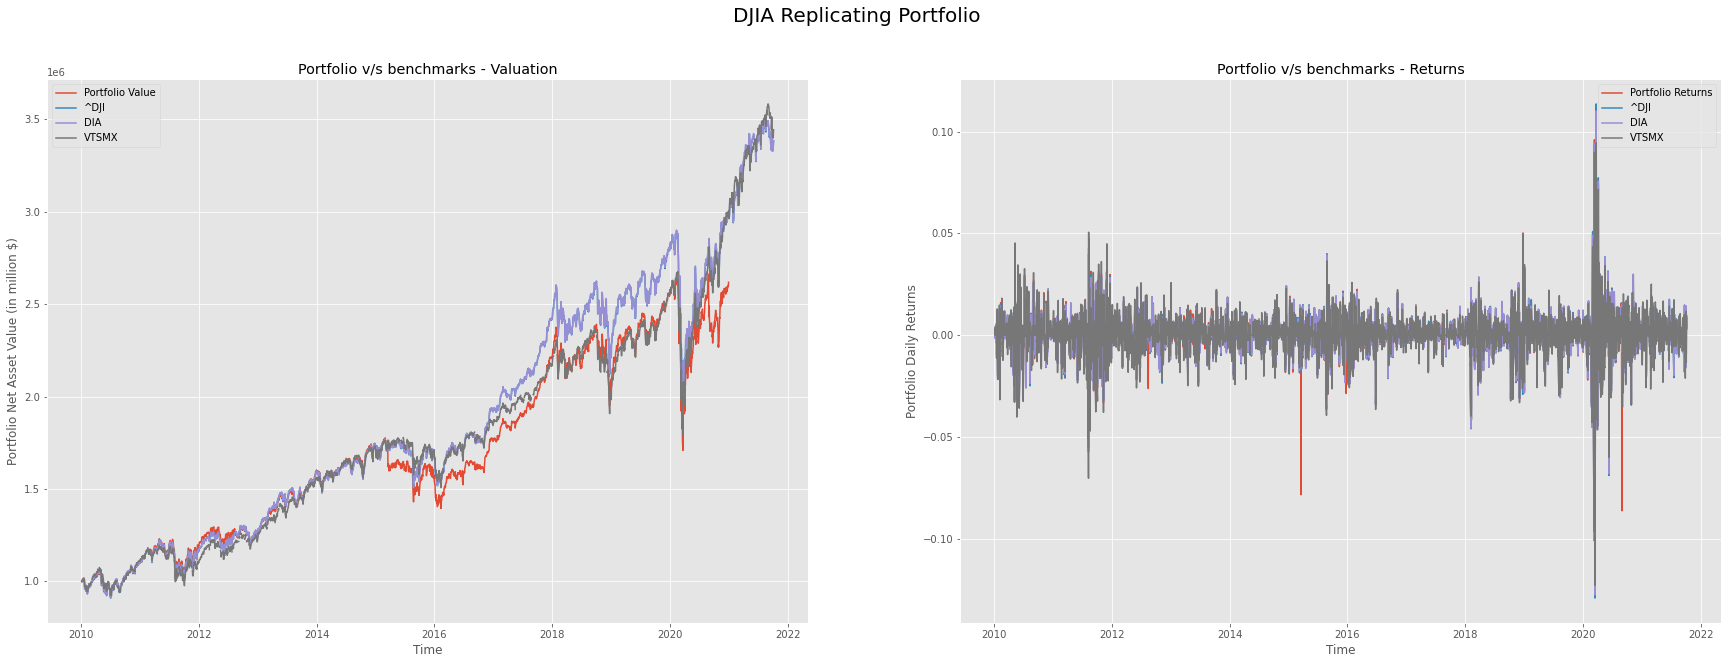

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot((benchmark_data["^DJI"]-584)*100)
ax[0].plot((benchmark_data["DIA"]-5.66)*10000)
ax[0].plot(benchmark_data["VTSMX"]*30000 + 162700)
ax[0].legend(["Portfolio Value","^DJI","DIA","VTSMX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^DJI"])
ax[1].plot(baseline_return["DIA"])
ax[1].plot(baseline_return["VTSMX"])
ax[1].legend(["Portfolio Returns","^DJI","DIA","VTSMX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

In [ ]:
tracking_error_djia = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_djia.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and DIA is 0.25%
Tracking error between our portfolio and VTSMX is 0.46499999999999997%
Tracking error between our portfolio and ^DJI is 0.23900000000000002%


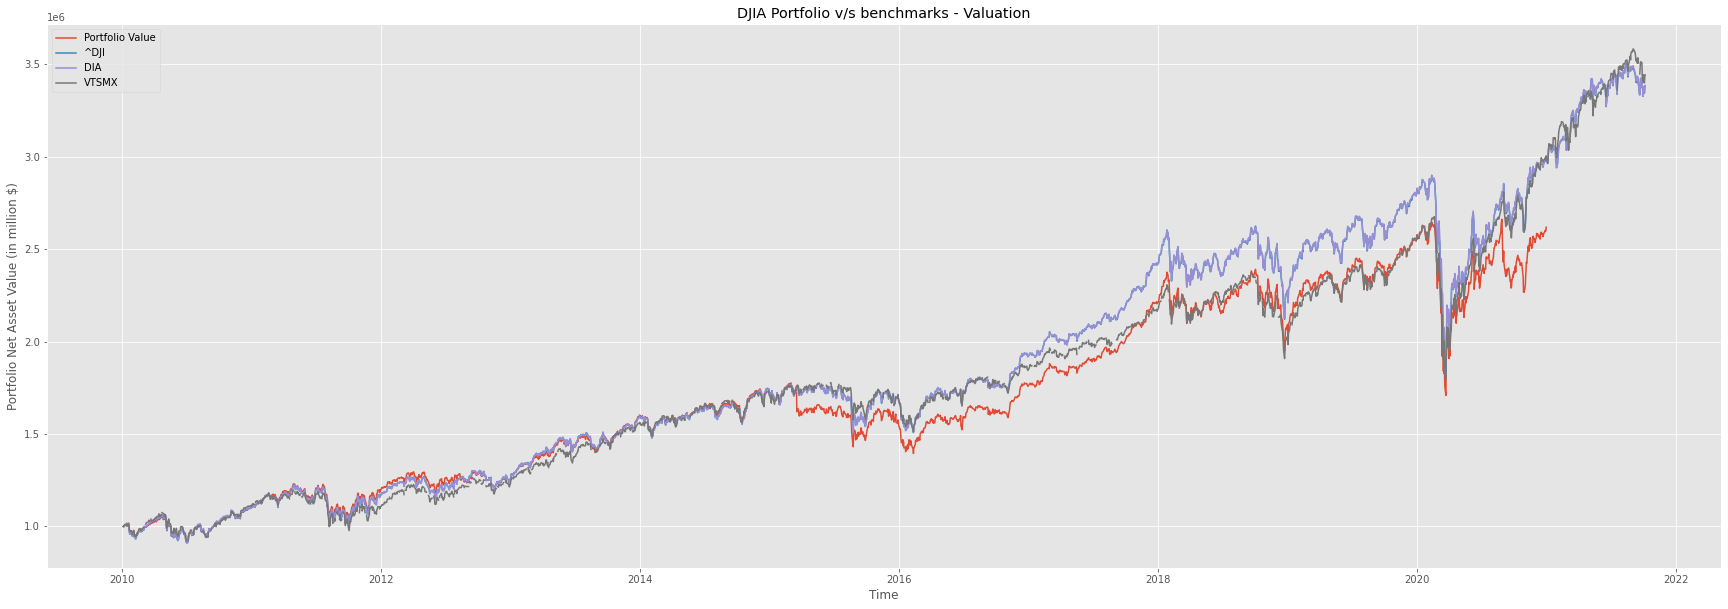

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot((benchmark_data["^DJI"]-584)*100)
plt.plot((benchmark_data["DIA"]-5.66)*10000)
plt.plot(benchmark_data["VTSMX"]*30000 + 162700)
plt.legend(["Portfolio Value","^DJI","DIA","VTSMX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("DJIA Portfolio v/s benchmarks - Valuation")
plt.show()

***
***